## To try?
- Check and quantify the consistence between detectors (H1 and V1)
- Determine how far away the source of GW is
- https://www.gw-openscience.org/eventapi/html/allevents/

In [2]:
from gwpy.timeseries import TimeSeries
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py
import os

In [3]:
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='kbgrcmy')

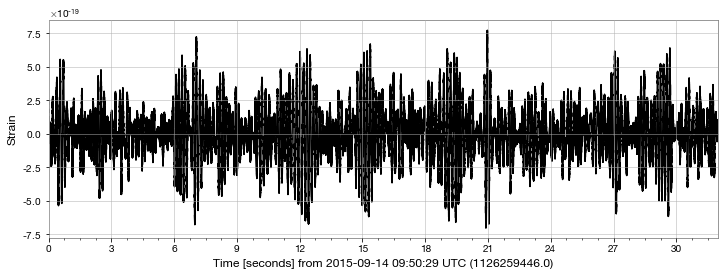

<Figure size 432x288 with 0 Axes>

In [4]:
#----------------------------------------------------------------
# Set parameters
#----------------------------------------------------------------
fn = 'data/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5' # data file
tevent = 1126259462.4 

#----------------------------------------------------------------
# Load LIGO data
#----------------------------------------------------------------
strain = TimeSeries.read(fn, format='hdf5.losc')
center = int(tevent)
strain = strain.crop(center-16, center+16)

#----------------------------------------------------------------
# Show LIGO strain vs. time
#----------------------------------------------------------------
plt.clf()
plt.figure()
strain.plot()
plt.ylabel('Strain')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'font.family': 'cmr10', 'mathtext.fontset': 'cm'})
# plt.rcParams.update({'font.family': 'cmss10', 'mathtext.fontset': 'stixsans'})
plt.savefig('plots/strain_r.png')

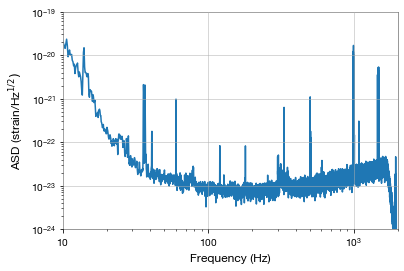

In [45]:
#----------------------------------------------------------------
# Obtain the power spectrum density PSD / ASD
#----------------------------------------------------------------

asd = strain.asd(fftlength=8)

plt.clf()
asd.plot()
plt.xlim(10, 2000)
plt.ylim(1e-24, 1e-19)
plt.ylabel('ASD (strain/Hz$^{1/2})$')
plt.xlabel('Frequency (Hz)')
plt.show()

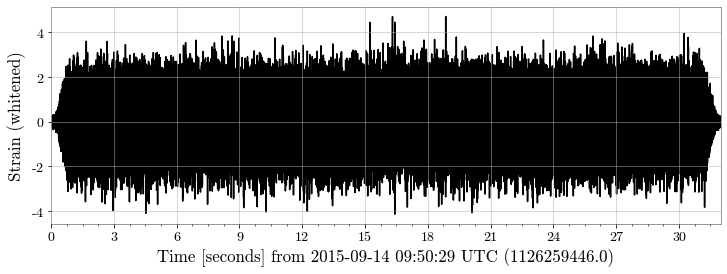

In [5]:
#----------------------------------------------------------------
# Whitening data
#----------------------------------------------------------------

white_data = strain.whiten()

plt.clf()
white_data.plot()
plt.ylabel('Strain (whitened)')
plt.rcParams.update({'font.size': 14})
plt.savefig('plots/whitened_r.png')

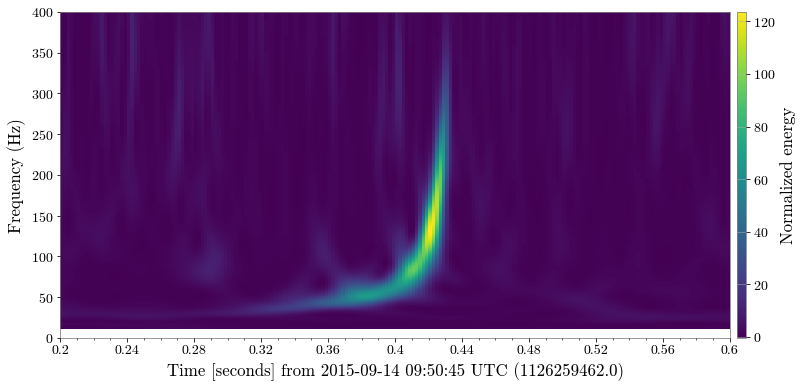

In [6]:
#----------------------------------------------------------------
# q-transform
#----------------------------------------------------------------

dt = 1  #-- Set width of q-transform plot, in seconds
hq = strain.q_transform(outseg=(tevent-dt, tevent+dt))

plt.clf()
fig = hq.plot()
ax = fig.gca()
fig.colorbar(label="Normalized energy")
ax.grid(False)
plt.xlim(tevent-0.2, tevent+0.2)
plt.ylim(0, 400)
plt.ylabel('Frequency (Hz)')
plt.savefig('plots/qtrans_r.png')

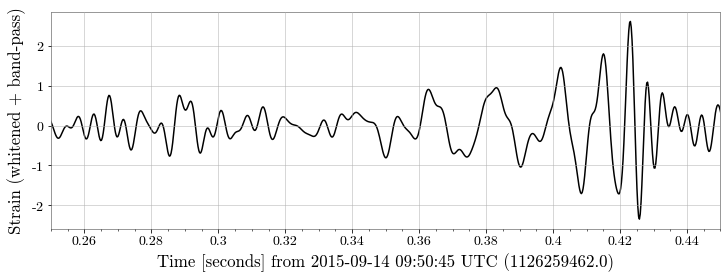

In [7]:
#----------------------------------------------------------------
# Bandpass filtering
#----------------------------------------------------------------

bandpass_low = 40
bandpass_high = 250

white_data_bp = white_data.bandpass(bandpass_low, bandpass_high)

plt.clf()
white_data_bp.plot()
plt.ylabel('Strain (whitened + band-pass)')
plt.savefig('plots/bandpass_r.png')

plt.clf()
white_data_bp.plot()
plt.ylabel('Strain (whitened + band-pass)')
plt.xlim(tevent-0.15, tevent+0.05)
plt.savefig('plots/zoom_r.png')

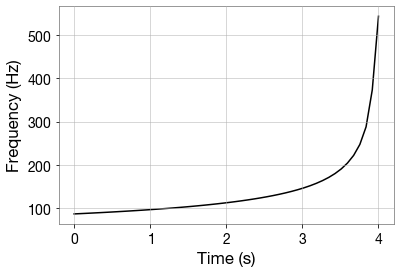

In [6]:
#----------------------------------------------------------------
# Frequency analytic
#----------------------------------------------------------------

def gwfreq(iM,iT,iT0,cutoff=3e-2):
    const = (948.5)*np.power((1./iM),5./8.)
    output = const*np.power(np.maximum((iT0-iT),cutoff),-3./8.)
    return output

times = np.linspace(0., 4., 50)
freq = gwfreq(20, times, 4)

plt.clf()
plt.plot(times, freq)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [7]:
import lmfit

In [8]:
def osc(t, Mc, t0, C, phi):
    return C * np.power(Mc * gwfreq(Mc, t, t0), 10/3) * np.cos(gwfreq(Mc, t, t0) * (t0-t) + phi) * np.power(1e-40, np.heaviside(t - t0, 0) * (t - t0))

In [9]:
def osc_post(t, Mc, t0, C, phi):
    return C * np.power(Mc * gwfreq(Mc, t, t0, 10**(-2.9)), 10/3) * np.cos(gwfreq(Mc, t, t0, 10**(-2.9)) * (t0-t) + phi) * np.power(1e-90, np.heaviside(t - t0, 0) * (t - t0))

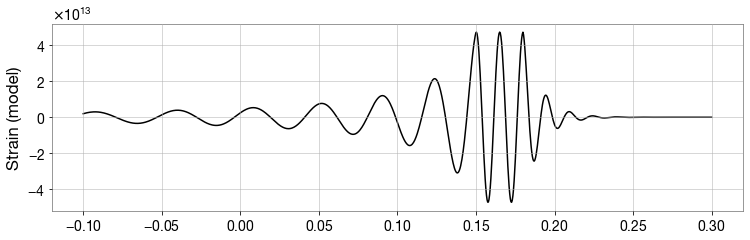

In [19]:
times = np.linspace(-0.1, 0.3, 1000)
freq = osc(times, 30, 0.18, 1, 0.0)
freq2 = osc_post(times, 30, 0.18, 0.03, 0.0)
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(times, freq, 'k')
# plt.plot(times, freq2, 'r')
#plt.xlabel('Time (s) since '+str(tevent))
plt.ylabel('Strain (model)')
plt.show()


In [10]:
def osc_dif(params, x, data, eps):
    iM=params['Mc']
    iT0=params['t0']
    norm=params['C']
    phi=params['phi']
    val=osc(x, iM, iT0, norm, phi)
    return (val-data)/eps

def osc_post_dif(params, x, data, eps):
    iM=params['Mc']
    iT0=params['t0']
    norm=params['C']
    phi=params['phi']
    val=osc_post(x, iM, iT0, norm, phi)
    return (val-data)/eps

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 231
    # data points      = 697
    # variables        = 4
    chi-square         = 0.45103817
    reduced chi-square = 6.5085e-04
    Akaike info crit   = -5110.06313
    Bayesian info crit = -5091.87599
[[Variables]]
    Mc:   14.4878201 +/- 0.17163311 (1.18%) (init = 20)
    t0:   0.15913707 +/- 5.8018e-04 (0.36%) (init = 0.14)
    C:   -5.2062e-14 +/- 2.6832e-15 (5.15%) (init = 1e-10)
    phi: -13.7225597 +/- 0.42442187 (3.09%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, phi) = -0.982
    C(Mc, phi) =  0.902
    C(Mc, t0)  = -0.838
    C(Mc, C)   =  0.276
    C(C, phi)  =  0.241
    C(t0, C)   = -0.222


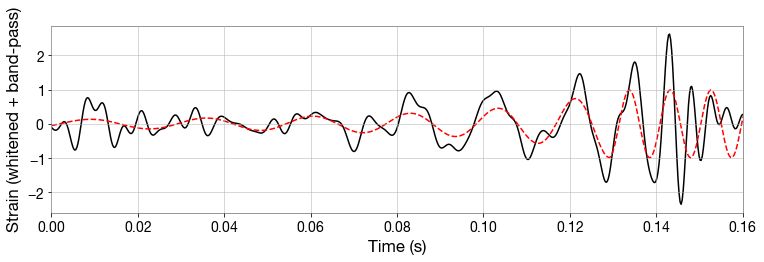

In [36]:
#----------------------------------------------------------------
# Naive Fit
#----------------------------------------------------------------

sample_times = white_data_bp.times.value
sample_data = white_data_bp.value
indxt = np.where((sample_times >= (tevent-0.12)) & (sample_times < (tevent+0.05)))
x = sample_times[indxt]
x = x-x[0]
white_data_bp_zoom = sample_data[indxt]

plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(x, white_data_bp_zoom)
plt.xlabel('Time (s)')
plt.ylabel('Strain (whitened + band-pass)')

import lmfit
from lmfit import Model, minimize, fit_report, Parameters

model = lmfit.Model(osc)
p = model.make_params()
p['Mc'].set(20)     # Mass guess
p['t0'].set(0.14)  # By construction we put the merger in the center
p['C'].set(1e-10)      # normalization guess
p['phi'].set(0)    # Phase guess
unc = np.full(len(white_data_bp_zoom),20)
out = minimize(osc_dif, params=p, args=(x, white_data_bp_zoom, unc))
print(fit_report(out))
plt.plot(x, model.eval(params=out.params,t=x),'r--',label='best fit')
plt.xlim(0, 0.16)
plt.show()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 100
    # data points      = 160
    # variables        = 4
    chi-square         = 0.03379065
    reduced chi-square = 2.1661e-04
    Akaike info crit   = -1346.03921
    Bayesian info crit = -1333.73851
[[Variables]]
    Mc:   26.1348839 +/- 0.77634372 (2.97%) (init = 30)
    t0:  -0.00228305 +/- 1674.30221 (73336148.56%) (init = 0.001)
    C:   -1.5955e-15 +/- 5.5032e-10 (34490721.56%) (init = 1e-10)
    phi:  3.64166083 +/- 2526900.68 (69388688.13%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, phi) = -1.000
    C(C, phi)  = -1.000
    C(t0, C)   =  1.000
    C(Mc, C)   =  0.104
    C(Mc, phi) = -0.104
    C(Mc, t0)  =  0.104
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 156
    # data points      = 516
    # variables        = 4
    chi-square         = 0.18553703
    reduced chi-square = 3.6238e-04
    Akaike info crit   = -4084.19351
    Baye

<Figure size 432x288 with 0 Axes>

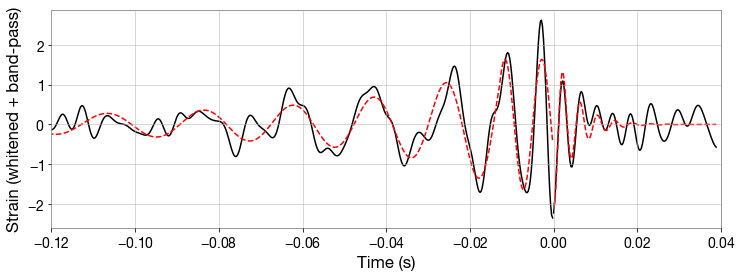

In [37]:
#NRtime, NR_H1 = np.genfromtxt('data/GW150914_4_NR_waveform.txt').transpose()
plt.clf()
plt.figure(figsize=(12, 4))
#plt.plot(NRtime, NR_H1)
plt.xlim(-0.12, 0.04)

indxtpost = np.where((sample_times >= (tevent+0.026)) & (sample_times < (tevent+0.065)))
xpost = sample_times[indxtpost]
xpt = xpost[0]
xpost = xpost-xpt
white_data_bp_zoom_post = sample_data[indxtpost]
plt.plot(xpost, white_data_bp_zoom_post, 'k')

indxtpre = np.where((sample_times >= (tevent-0.1)) & (sample_times < (tevent+0.026)))
xpre = sample_times[indxtpre]
xpre = xpre-xpt
white_data_bp_zoom_pre = sample_data[indxtpre]
plt.plot(xpre, white_data_bp_zoom_pre, 'k')
plt.xlabel('Time (s)')
plt.ylabel('Strain (whitened + band-pass)')

model = lmfit.Model(osc_post)
p = model.make_params()
p['Mc'].set(30)     
p['t0'].set(0.001)  
p['C'].set(1e-10)
p['phi'].set(0)
out = minimize(osc_post_dif, params=p, args=(xpost, white_data_bp_zoom_post, np.full(len(white_data_bp_zoom_post),20)))
print(fit_report(out))
plt.plot(xpost, model.eval(params=out.params,t=xpost),'r--',label='best fit')

model = lmfit.Model(osc)
p = model.make_params()
p['Mc'].set(30)     
p['t0'].set(-0.005)  
p['C'].set(1e-10)
p['phi'].set(0)
out = minimize(osc_dif, params=p, args=(xpre, white_data_bp_zoom_pre, np.full(len(white_data_bp_zoom_pre),20)))
print(fit_report(out))
plt.plot(xpre, model.eval(params=out.params,t=xpre),'r--',label='best fit')
plt.show()

In [8]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

def make_error_boxes(ax, xdata, ydata, xerror, yerror, facecolor='r',
                     edgecolor='None', alpha=0.25):

    # Loop over data points; create box from errors at each point
    errorboxes = [Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
                  for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T)]

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha,
                         edgecolor=edgecolor)

    # Add collection to axes
    ax.add_collection(pc)

    # Plot errorbars
    artists = ax.errorbar(xdata, ydata, xerr=xerror, yerr=yerror,
                          fmt='None', ecolor='k')

    return artists

<Figure size 432x288 with 0 Axes>

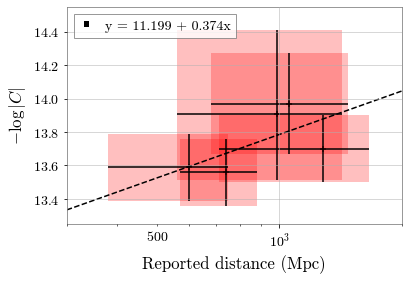

In [26]:
plt.clf()
fig, ax = plt.subplots()
ax.set_xscale('log')
x = [990, 600, 1060, 740, 1280]
y = [13.91, 13.59, 13.97, 13.56, 13.70]
plt.scatter(x, y, marker='+')
plt.xlim(300, 2000)
plt.ylim(13.25, 14.55)
plt.xlabel('Reported distance (Mpc)')
plt.ylabel(r'$- \log \, | C |$')
xerr = [[430, 440], [220, 150], [380, 420], [170, 140], [570, 380]]
yerr = [[0.4, 0.5], [0.2, 0.2], [0.3, 0.3], [0.2, 0.2], [0.2, 0.2]]
_ = make_error_boxes(ax, np.asarray(x), np.asarray(y), np.asarray(xerr).T, np.asarray(yerr).T)
plt.plot([300 + 10*i for i in range(170 + 1)], res.intercept + res.slope*np.log([300 + 10*i for i in range(170 + 1)]), 'k--', label='y = 11.199 + 0.374x')
ax.legend(loc='upper left')
plt.savefig('plots/luminosity_pres.png', bbox_inches='tight', pad_inches=0.1)

In [18]:
from scipy.stats import linregress

In [19]:
res = linregress(np.log(x), y)
print(f"R-squared: {res.rvalue**2:.6f}")
print(res.intercept, res.slope)

R-squared: 0.367900
11.198826549538413 0.37434294219553194


In [20]:
print(res.rvalue)

0.6065475873971918


In [ ]:
xe = [990, 600, 1060, 740, 1280, 3300]
ye = [13.91, 13.59, 13.97, 13.56, 13.70, 13.52]
xerre = [[430, 440], [220, 150], [380, 420], [170, 140], [570, 380], [1500, 1540]]
yerre = [[0.4, 0.5], [0.2, 0.2], [0.3, 0.3], [0.2, 0.2], [0.2, 0.2], [0.3, 0.3]]